# apacheApsVar, apachePredVar, apachePatientResult

These three tables are used to document data relating to the APACHE IV / APACHE IVa systems. These systems provide predictions for in-hospital mortality, length of stay, length of mechanical ventilation, among others. The data used to create these predictions is stored in the apacheApsVar and apachePredVar tables. The result of the predictions, along with the observed outcome, is stored in the apachePatientResult table.

## History of APACHE

Acute Physiology Age Chronic Health Evaluation (APACHE) consists of a groups of equations used for predicting outcomes in critically ill patients. APACHE II is based on the APS or acute physiology score (which uses 12 physiologic values), age, and chronic health status within one of 56 disease groups. APACHE II is no longer considered valid due to inadequate case mix index adjustments and over estimates mortality because it is based on models from the 1970s-1980s. APACHE III, introduced in 1991, improved the equation by changing the number and weights of the APS and revising the measurement of chronic health status. APACHE IVa further improved the equations and has been described as having the highest discrimination of any other adult risk adjustment model (SAPS 3, SOFA, MPM III).

Practically, this means:

1. The `acutePhysiologyScore` calculated and provided is identical to that published with APACHE III, i.e. it is the Acute Physiology Score (APS) III. There is no such thing as an APS IV.
2. The `apacheScore` calculated and provided is identical to that published with APACHE III.
3. The final prediction, e.g. `predictedHospitalMortality`, is the output of the APACHE IV or APACHE IVa model, respectively, and uses the `apacheScore` as an input. The `apacheScore` in turn uses the `acutePhysiologyScore` as an input.

## Using the tables

If you are interested in the underlying data, the apacheApsVar and apachePredVar have the physiology and other covariates which drive the APACHE predictions. These tables have one row per `patientUnitStayId`.

If you are interested in the predictions and/or outcomes for the patients, the apachePatientResult table contains this data. **The apachePatientResult table contains two rows per `patientUnitStayId`**: one for APACHE IV, and one for APACHE IVa.

## apachePatientResult

`physicianSpeciality` | varchar(50) | NULL | Physician Specialty picklist value |  | S
`physicianInterventionCategory` | varchar(50) | NULL | Physician Intervention Category picklist value |  | S
`acutePhysiologyScore` | int | NULL | Acute Physiology Score from Apache API |  | S
`apacheScore` | int | NULL | Apache Score. Calculated from acutePhysiologyScore |  | S
`apacheVersion` | tinyint | NOT NULL | The version of the APACHE algorithm used to produce the apacheScore (e.g 3, 4) |  | S
`predictedICUMortality` | varchar(50) | NULL | Predicted ICU Mortality from Apache API |  | S
`actualICUMortality` | varchar(50) | NULL | Actual ICU Mortality |  | S
`predictedICULOS` | float(53) | NULL | Predicted ICU Length of Stay from Apache API |  | S
`actualICULOS` | float(53) | NULL | Actual ICU Length of Stay |  | S
`predictedHospitalMortality` | varchar(50) | NULL | Predicted Hospital Mortality from Apache API |  | S
`actualHospitalMortality` | varchar(50) | NULL | Actual Hospital Mortality |  | S
`predictedHospitalLOS` | float(53) | NULL | Predicted Hospital Length of Stay from Apache API |  | S
`actualHospitalLOS` | float(53) | NULL | Actual Hospital Length of Stay. Value is 50 when when > 50 days. |  | S
`preopMI` | int | NULL | Indicates if patient has pre –Operative Myocardial Infarction |  | S
`preopCardiacCath` | int | NULL | Indicates if patient has pre –Operative cardiac catheterization |  | S
`PTCAwithin24h` | int | NULL | 0/1. 1- Patient had PTCA with 24 hrs |  | S
`unabridgedUnitLOS` | float(53) | NULL | Actual ICU Length of stay |  | S
`unabridgedHospLOS` | float(53) | NULL | Actual Hospital Length of stay |  | S
`actualVentdays` | float(53) | NULL | Actual Ventilation days. Value is 30 when Actual Ventilation > 30 |  | S
`predVentdays` | float(53) | NULL | Predicted ventilation days from Apache API |  | S
`unabridgedActualVentdays` | float(53) | NULL | Actual Ventilation days |  | S


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 2704494

In [4]:
query = query_schema + """
select *
from apacheapsvar
where patientunitstayid = {}
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,apacheapsvarid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,2704494,2305985,0,0,1,4,6,5,0,-1.0,...,-1.0,21.9,2.81,-1.0,-1.0,-1.0,70.0,119.0,-1.0,-1.0


## Missing data represented by -1

## apacheScore present but prediction is -1

## Ventilation flags

## Unable to assess GCS (`meds` column)

## Hospitals with data available

In [5]:
query = query_schema + """
select 
  pt.hospitalid
  , count(pt.patientunitstayid) as number_of_patients
  , count(a.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join apacheapsvar a
  on pt.patientunitstayid = a.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
43,73,7059,5984,84.771214
7,264,5237,4878,93.144930
165,420,4679,4090,87.411840
156,338,4277,4079,95.370587
170,167,6092,3620,59.422193
190,458,3701,3544,95.757903
145,188,3601,3540,98.306026
189,300,3617,3518,97.262925
166,443,3656,3495,95.596280
25,208,3650,3361,92.082192


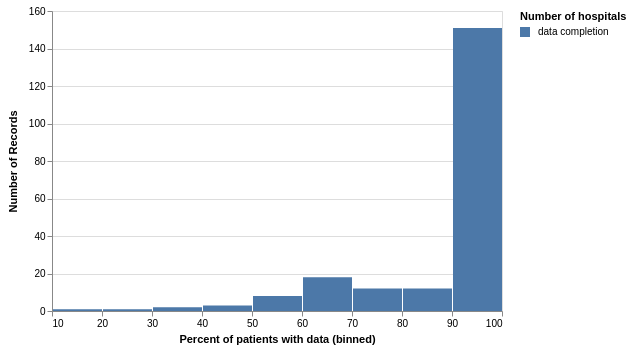

In [6]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

As we can see, the majority of hospitals collect APACHE data.